# **CSE47201 Computer Vision Programming Assignment 1**
## Problem 2

### Import library

In [1]:
import cv2
import numpy as np
from tqdm import tqdm

### Bag-of-words model

In [2]:
ls dataset/train

Faces/         cougar_face/  flamingo/   nautilus/     sunflower/
Faces_easy/    dalmatian/    headphone/  pagoda/       tick/
brontosaurus/  dollar_bill/  lotus/      soccer_ball/  windsor_chair/
car_side/      dragonfly/    menorah/    stop_sign/    yin_yang/


#### Retrieve all categories

In [3]:
import os
base_path = "dataset/train"
categories = [name for name in os.listdir(base_path)]
detector = cv2.ORB_create()

In [4]:
categories

['brontosaurus',
 'car_side',
 'cougar_face',
 'dalmatian',
 'dollar_bill',
 'dragonfly',
 'Faces',
 'Faces_easy',
 'flamingo',
 'headphone',
 'lotus',
 'menorah',
 'nautilus',
 'pagoda',
 'soccer_ball',
 'stop_sign',
 'sunflower',
 'tick',
 'windsor_chair',
 'yin_yang']

#### Obtain and compute features of images

In [5]:
train_paths = []
train_labels = []
train_features = np.array([])
img_len = 30
count = 0

In [6]:
# Loop through every images
for idx, category in enumerate(categories):
    dir_path = base_path + '/' + category
    
    for i in range(img_len):
        # Obtain the image path and labels
        img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
        train_paths.append(img_path)
        train_labels.append(idx)
        
        # Read image
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Obtain features
        kpt, desc = detector.detectAndCompute(gray, None)

        # Save images' features
        if train_features.size == 0:
            train_features = np.float32(desc)
        else:
            train_features = np.append(train_features, np.float32(desc), axis=0)

        count+=1
        print('%d/%d - %s - %d feature points are detected\n' % (count, img_len*len(categories), img_path, desc.shape[0]))

1/600 - dataset/train/brontosaurus/image_0001.jpg - 392 feature points are detected

2/600 - dataset/train/brontosaurus/image_0002.jpg - 427 feature points are detected

3/600 - dataset/train/brontosaurus/image_0003.jpg - 430 feature points are detected

4/600 - dataset/train/brontosaurus/image_0004.jpg - 391 feature points are detected

5/600 - dataset/train/brontosaurus/image_0005.jpg - 445 feature points are detected

6/600 - dataset/train/brontosaurus/image_0006.jpg - 417 feature points are detected

7/600 - dataset/train/brontosaurus/image_0007.jpg - 414 feature points are detected

8/600 - dataset/train/brontosaurus/image_0008.jpg - 331 feature points are detected

9/600 - dataset/train/brontosaurus/image_0009.jpg - 415 feature points are detected

10/600 - dataset/train/brontosaurus/image_0010.jpg - 424 feature points are detected

11/600 - dataset/train/brontosaurus/image_0011.jpg - 330 feature points are detected

12/600 - dataset/train/brontosaurus/image_0012.jpg - 397 featur

#### SVM Classifier implementation

In [7]:
# SVM image classifier
class Classifier:

    # Constructor
    # code_words: the number of codewords
    # base_path: path contains the data
    def __init__(self, code_words, base_path):
        # Load the dictionary file
        self.dictionary = np.load("dictionary.npy")
        self.dictionary_size = code_words

        # Create instance of KNN algorithm
        self.knn = cv2.ml.KNearest_create()

        # Obtain images path
        self.train_paths = []
        self.train_labels = []
        for idx, category in enumerate(categories):
            dir_path = base_path + '/' + category
            for i in range(img_len):
                img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)

                # Store labels and path
                self.train_paths.append(img_path)
                self.train_labels.append(idx)

        # Create histogram of codewords
        self.hists = np.float32(np.zeros((len(self.train_paths), self.dictionary_size)))

        # Create SVM
        self.svm = cv2.ml.SVM_create()


    # Start training KNN
    def train_knn(self):
        # Train KNN
        self.knn.train(self.dictionary, cv2.ml.ROW_SAMPLE, np.float32(range(self.dictionary_size)))

        # Loop to update histogram of codewords
        for i, path in enumerate(self.train_paths):
            # Read images
            img = cv2.imread(path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Obtain features
            kpt, desc = detector.detectAndCompute(gray, None)

            # Clustering
            ret, result, neighbours, dist = self.knn.findNearest(np.float32(desc), k=1)
            hist, bins = np.histogram(np.int32(result), bins=range(self.dictionary_size + 1))

            # Update histogram
            self.hists[i, :] = np.float32(hist) / np.float32(np.sum(hist))


    # Train SVM
    # file_name=place to save the model
    def fit(self, file_name="svmmodel.xml"):
        self.train_knn()
        svm_model_file = file_name
        # Train SVM
        self.svm.train(self.hists, cv2.ml.ROW_SAMPLE, np.array(self.train_labels))
        # Save SVM
        self.svm.save(svm_model_file)

    # Get prediction
    def predict(self, test_desc):
        return self.svm.predict(test_desc)


    # Get prediction
    # img_path=Path to the image
    def get_prediction(self, img_path):
        # Read image
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Obtain features
        kpt, desc = detector.detectAndCompute(gray, None)
        ret, result, neighbours, dist = self.knn.findNearest(np.float32(desc), k=1)

        # Get histogram
        hist1, bins = np.histogram(np.int32(result), bins=range(self.dictionary_size + 1))
        test_desc = np.float32(np.zeros((1, self.dictionary_size)))
        test_desc[0, :] = np.float32(hist1) / np.float32(np.sum(hist1))

        # Predict the category
        ret, result = self.predict(test_desc)
        return result

In [8]:
# Create an instance of Classifier with other codewords and kernels
def svm_classifier(code_words, kernel = None):
    # Dictionary path
    dict_file = "dictionary.npy"
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)

    # Start K-means algorithm
    ret, label, dictionary = cv2.kmeans(train_features, code_words, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Save the dictionary
    np.save(dict_file, dictionary)

    # Create the model
    model = Classifier(code_words=code_words, base_path=base_path)

    # If a kernel is set
    if kernel is not None:
        model.svm.setKernel(kernel)

    # Train SVM
    model.fit()

    return model

#### Accuracy computation

In [9]:
# Obtain training accuracy
def get_train_accuracy(model):
    total_sample, total_correct = 0, 0

    # Loop through every category
    for idx, category in enumerate(categories):
        dir_path = "dataset/train" + '/' + category

        # Loop through every sample of that category
        for i in range(img_len):
            img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
            total_sample += 1

            # If the prediction is correct, increase total_correct by 1
            total_correct += int(idx == model.get_prediction(img_path)[0, 0])

    # Return the accuracy
    return total_correct / total_sample

In [10]:
# Obtain training accuracy
def get_test_accuracy(model):
    total_sample, total_correct = 0, 0

    # Loop through every category
    for idx, category in enumerate(categories):
        dir_path = "dataset/test" + '/' + category
        
        # Loop through every sample of that category
        for i in range(30, 35):
            img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
            total_sample += 1
            
            # If the prediction is correct, increase total_correct by 1
            total_correct += int(idx == model.get_prediction(img_path)[0, 0])

    # Return the accuracy
    return total_correct / total_sample

#### Hyperparameters

In [11]:
train_acc = []
test_acc = []
MAX_CODEWORDS = 500

#### Train SVM with different codewords

In [12]:
for code_words in range(20, MAX_CODEWORDS + 1, 20):
    # Create model with codewords
    model = svm_classifier(code_words)

    # Save accuracies
    train_acc.append(get_train_accuracy(model))
    test_acc.append(get_test_accuracy(model))

    # Monitor the process
    print(f"{code_words} code words accuracy: train({train_acc[-1]:.6f})\t test({test_acc[-1]:.6f})")

20 code words accuracy: train(0.276667)	 test(0.250000)
40 code words accuracy: train(0.298333)	 test(0.280000)
60 code words accuracy: train(0.350000)	 test(0.310000)
80 code words accuracy: train(0.361667)	 test(0.300000)
100 code words accuracy: train(0.381667)	 test(0.330000)
120 code words accuracy: train(0.378333)	 test(0.350000)
140 code words accuracy: train(0.378333)	 test(0.370000)
160 code words accuracy: train(0.411667)	 test(0.320000)
180 code words accuracy: train(0.393333)	 test(0.330000)
200 code words accuracy: train(0.391667)	 test(0.340000)
220 code words accuracy: train(0.415000)	 test(0.380000)
240 code words accuracy: train(0.411667)	 test(0.340000)
260 code words accuracy: train(0.416667)	 test(0.390000)
280 code words accuracy: train(0.426667)	 test(0.400000)
300 code words accuracy: train(0.428333)	 test(0.360000)
320 code words accuracy: train(0.445000)	 test(0.400000)
340 code words accuracy: train(0.416667)	 test(0.390000)
360 code words accuracy: train(0.46

##### Plot the accuracy

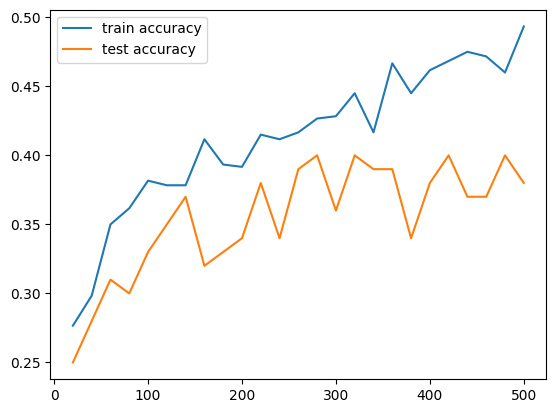

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(20, MAX_CODEWORDS + 1, 20), train_acc, label="train accuracy")
plt.plot(range(20, MAX_CODEWORDS + 1, 20), test_acc, label="test accuracy")
plt.legend(loc="upper left")

As we can see from the graph, the accuracy is increasing a long with the number of codewords.

Both train and test accuracy are tranding upward. However, test accuracy starts to converge to a point near 40%.

#### Train SVM with histogram intersection kernel

In [14]:
train_acc = []
test_acc = []

In [15]:
for code_words in range(20, MAX_CODEWORDS + 1, 20):
    # Create model with codewords and kernel
    model = svm_classifier(code_words, cv2.ml.SVM_INTER)

    # Save accuracies
    train_acc.append(get_train_accuracy(model))
    test_acc.append(get_test_accuracy(model))

    # Monitor the result
    print(f"{code_words} code words accuracy: train({train_acc[-1]:.6f})\t test({test_acc[-1]:.6f})")

20 code words accuracy: train(0.490000)	 test(0.400000)
40 code words accuracy: train(0.583333)	 test(0.460000)
60 code words accuracy: train(0.643333)	 test(0.470000)
80 code words accuracy: train(0.688333)	 test(0.480000)
100 code words accuracy: train(0.760000)	 test(0.510000)
120 code words accuracy: train(0.776667)	 test(0.480000)
140 code words accuracy: train(0.810000)	 test(0.540000)
160 code words accuracy: train(0.838333)	 test(0.540000)
180 code words accuracy: train(0.853333)	 test(0.550000)
200 code words accuracy: train(0.845000)	 test(0.560000)
220 code words accuracy: train(0.868333)	 test(0.550000)
240 code words accuracy: train(0.888333)	 test(0.550000)
260 code words accuracy: train(0.908333)	 test(0.590000)
280 code words accuracy: train(0.903333)	 test(0.570000)
300 code words accuracy: train(0.935000)	 test(0.580000)
320 code words accuracy: train(0.908333)	 test(0.560000)
340 code words accuracy: train(0.933333)	 test(0.580000)
360 code words accuracy: train(0.93

##### Plot the accuracy

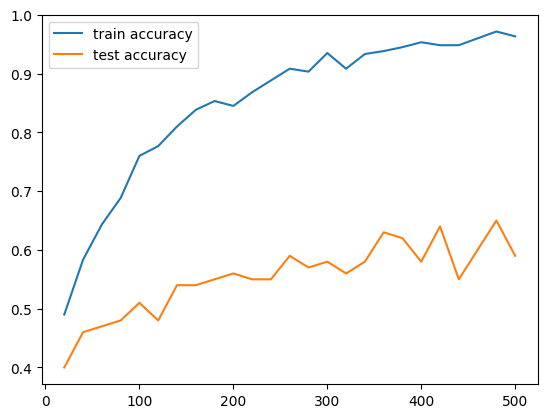

In [16]:
plt.plot(range(20, MAX_CODEWORDS + 1, 20), train_acc, label="train accuracy")
plt.plot(range(20, MAX_CODEWORDS + 1, 20), test_acc, label="test accuracy")
plt.legend(loc="upper left")

As we can see from the graph, the accuracy is increasing a long with the number of codewords.

Both train and test accuracy are tranding upward. However, test accuracy starts to converge at around 60%.

Comparing with the default kernel, histogram intersection kernel yields a better accuracy, both for train and test dataset.